In [2]:
import glob
import json
import os
import re
from typing import Dict, Tuple, Union, List, Optional

import einops
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import SimpleITK as sitk

In [3]:
def debug_print(*args, show: bool = False, **kwargs):
    if show:
        print(*args, **kwargs)

In [8]:
def data_proc(dcm_root: Union[os.PathLike, str],
              nrrd_root: Union[os.PathLike, str],
              exclude_id: List[str] = [],
              need_to_show: List[str] = [],
              need_to_reverse: List[str] = [],
              should_shift: Dict[str, int] = {},
              debug: bool = False):
    masks_imgs = np.zeros((0, 1, 512, 512))
    cts_imgs = np.zeros((0, 1, 512, 512))
    data_descr: Dict[str, Tuple[int, int, int]] = {}  # id : [start, end, total]

    rtss_paths = list(glob.glob(os.path.join(dcm_root, "**", "RS.*.dcm"), recursive=True))
    total_count = 0
    for rtss_idx, rtss_path in enumerate(rtss_paths):
        rtss_dcm = pydicom.dcmread(rtss_path)
        ct_paths = [
            f"{os.path.split(rtss_path)[0]}/CT.{p.ReferencedSOPInstanceUID}.dcm"
            for p in rtss_dcm.ReferencedFrameOfReferenceSequence[0].RTReferencedStudySequence[0].RTReferencedSeriesSequence[0].
            ContourImageSequence
        ]
        try:
            patient_id = re.findall(r"(\d+\w_\d{8})", rtss_path)[0]
        except IndexError:
            patient_id = rtss_path.split(os.sep)[-2]
        if patient_id in exclude_id:
            print(rtss_path, patient_id, "mask error")
            continue
        sitk_mask = sitk.ReadImage(os.path.join(nrrd_root, patient_id + ".nii.gz"))
        mask_img3d = sitk.GetArrayFromImage(sitk_mask)
        if patient_id in need_to_reverse:
            mask_img3d = mask_img3d[::-1]
            debug_print(f"{patient_id} reversed", show=debug or patient_id in need_to_show)
        if patient_id in should_shift:
            tmp = mask_img3d.copy()
            mask_img3d[should_shift[patient_id]:] = tmp[:-should_shift[patient_id]]  # 75 s10 => 0-65:10-75
            mask_img3d[:should_shift[patient_id]] = tmp[-should_shift[patient_id]:]  # => 65-75:0-10
            debug_print(f"{patient_id} shift {should_shift[patient_id]}", show=debug or patient_id in need_to_show)

        try:
            sitk_cts = sitk.ReadImage(ct_paths)
        except RuntimeError as e:
            print(rtss_path, patient_id, e)
            continue
        ct_img3d = sitk.GetArrayFromImage(sitk_cts)

        try:
            start, end = [[i for i, img in enumerate(mask_img3d) if np.sum(img) > 1][j] for j in [0, -1]]
        except IndexError as e:
            print(rtss_path, patient_id, e)
            continue

        start, end = max(start - 5, 0), min(end + 6, len(mask_img3d))

        debug_print(rtss_path, show=debug or patient_id in need_to_show)
        debug_print(f"#{rtss_idx}",
                    patient_id,
                    start,
                    end,
                    mask_img3d.shape,
                    ct_img3d.shape,
                    show=debug or patient_id in need_to_show)

        if patient_id in need_to_show or debug:  # or end - start > 30 :
            plt.figure(figsize=(15, 60))
            for idx, i in enumerate(range(start, end)):
                plt.subplot(20, 6, idx + 1)
                cct_imgs = ((ct_img3d[i].copy() + 1000) / 2000).clip(0, 1)
                # cct_imgs[cct_imgs>0.4] = 0
                plt.imshow(einops.rearrange(np.array([mask_img3d[i], cct_imgs, np.zeros((512, 512))]), "c h w -> h w c"))
            plt.show()

        data_descr[patient_id] = (total_count, total_count + end - start, end - start)
        total_count += end - start
        cts_imgs = np.concatenate([cts_imgs, einops.rearrange(ct_img3d[start:end], "b h w -> b 1 h w")], axis=0)
        masks_imgs = np.concatenate([masks_imgs, einops.rearrange(mask_img3d[start:end], "b h w -> b 1 h w")], axis=0)
        debug_print(cts_imgs.shape, show=debug)

    return cts_imgs, masks_imgs, data_descr

In [5]:
def save_npy(cts_imgs, masks_imgs, data_descr, save_name: str = ''):
    np.save("mask" + save_name + ".npy", masks_imgs)
    np.save("ct" + save_name + ".npy", cts_imgs)
    with open("descr" + save_name + ".json", "w") as f:
        json.dump(data_descr, f)

In [6]:
def show_img_mask(cts_imgs, masks_imgs, data_descr):
    plt.figure(figsize=(20, 90))
    for idx, (k, v) in enumerate(data_descr.items()):
        plt.subplot(20, 6, idx + 1)
        i = (v[0] + v[1]) // 2
        cct_imgs = ((cts_imgs[i, 0].copy() + 1000) / 2000).clip(0, 1)
        # cct_imgs[cct_imgs>0.4] = 0
        plt.imshow(einops.rearrange(np.array([masks_imgs[i, 0], cct_imgs, np.zeros((512, 512))]), "c h w -> h w c"))
        plt.title(k)
    plt.show()

/root/projs/rili/RILI-2019-2020/RP-2019-46p111ct/002678845E_20200220/RS.1.2.246.352.221.52751835587698085323303123628842866094.dcm 002678845E_20200220 mask error
/root/projs/rili/RILI-2019-2020/RP-2019-46p111ct/002611250F_20200302/RS.1.2.246.352.221.48126480153269228672541651213242366637.dcm 002611250F_20200302 mask error


ImageSeriesReader (0x3839330): Non uniform sampling or missing slices detected,  maximum nonuniformity:389.936

ImageSeriesReader (0x3839330): Non uniform sampling or missing slices detected,  maximum nonuniformity:75

ImageSeriesReader (0x3839330): Non uniform sampling or missing slices detected,  maximum nonuniformity:75

ImageSeriesReader (0x3839330): Non uniform sampling or missing slices detected,  maximum nonuniformity:20



/root/projs/rili/RILI-2019-2020/RP-2019-46p111ct/002696532C_20190725/RS.1.2.246.352.221.50075862175596274496089353198955055273.dcm 002696532C_20190725 Exception thrown in SimpleITK ImageSeriesReader_Execute: /tmp/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:97:
sitk::ERROR: The file "/root/projs/rili/RILI-2019-2020/RP-2019-46p111ct/002696532C_20190725/CT.1.2.246.352.221.548846021475237360612869279859887242119.dcm" does not exist.
/root/projs/rili/RILI-2019-2020/RP-2019-46p111ct/001217894I_20191231/RS.1.2.246.352.221.52070705006704502801272170879893877920.dcm 001217894I_20191231 mask error


ImageSeriesReader (0x3839330): Non uniform sampling or missing slices detected,  maximum nonuniformity:75.2027

ImageSeriesReader (0x3839330): Non uniform sampling or missing slices detected,  maximum nonuniformity:75.0658



/root/projs/rili/RILI-2019-2020/RP-2019-46p111ct/001505416H_20201002/RS.1.2.246.352.221.517765292674925946917054598181793915828.dcm 001505416H_20201002 mask error


ImageSeriesReader (0x3839330): Non uniform sampling or missing slices detected,  maximum nonuniformity:25



/root/projs/rili/RILI-2019-2020/RP-2019-46p111ct/002719821G_20200102/RS.1.2.246.352.221.469017961556587055317423732825645979062.dcm 002719821G_20200102 mask error


ImageSeriesReader (0x3839330): Non uniform sampling or missing slices detected,  maximum nonuniformity:75

ImageSeriesReader (0x3839330): Non uniform sampling or missing slices detected,  maximum nonuniformity:75.9375

ImageSeriesReader (0x3839330): Non uniform sampling or missing slices detected,  maximum nonuniformity:75

ImageSeriesReader (0x3839330): Non uniform sampling or missing slices detected,  maximum nonuniformity:25

ImageSeriesReader (0x3839330): Non uniform sampling or missing slices detected,  maximum nonuniformity:15.1667



/root/projs/rili/RILI-2019-2020/RP-2019-46p111ct/001217894I_20190910/RS.1.2.246.352.221.511667031031388763912694339566899029161.dcm 001217894I_20190910 Exception thrown in SimpleITK ImageSeriesReader_Execute: /tmp/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:97:
sitk::ERROR: The file "/root/projs/rili/RILI-2019-2020/RP-2019-46p111ct/001217894I_20190910/CT.1.2.246.352.221.503065792066940230012216600369715953339.dcm" does not exist.


ImageSeriesReader (0x3839330): Non uniform sampling or missing slices detected,  maximum nonuniformity:232.353

ImageSeriesReader (0x3839330): Non uniform sampling or missing slices detected,  maximum nonuniformity:75



/root/projs/rili/RILI-2019-2020/RP-2019-46p111ct/002535827E_20200220/RS.1.2.246.352.221.46208195612064597315724040238763703722.dcm 002535827E_20200220 mask error


ImageSeriesReader (0x3839330): Non uniform sampling or missing slices detected,  maximum nonuniformity:76.3115

ImageSeriesReader (0x3839330): Non uniform sampling or missing slices detected,  maximum nonuniformity:15.1974



/root/projs/rili/RILI-2019-2020/RP-2019-46p111ct/000591350I_20191024/RS.1.2.246.352.221.527507519866931356713846904773282852526.dcm 000591350I_20191024 list index out of range


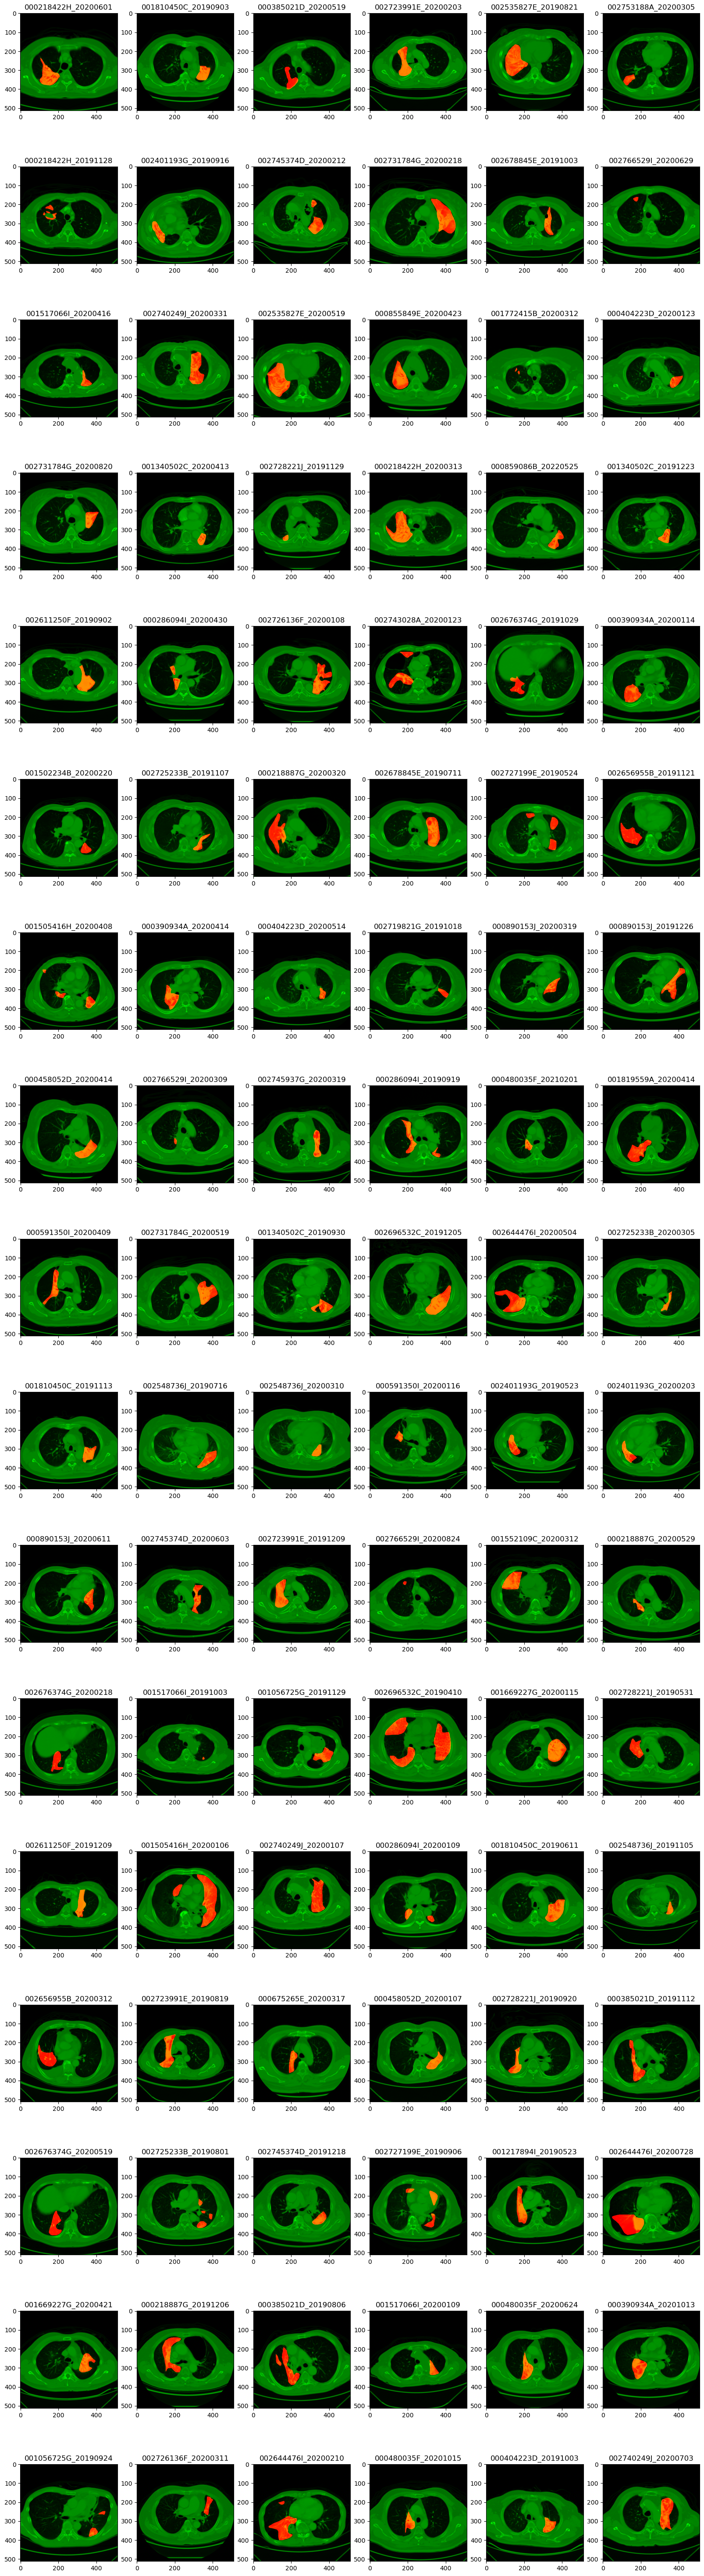

In [15]:
dcm_root = "/root/projs/rili/RILI-2019-2020/RP-2019-46p111ct/"
nrrd_root = "/root/projs/rili/RILI-2019-2020/RP-2019-46p111ct-nifty/"

# 002678845E_20200220 002611250F_20200302 002719821G_20200102 002535827E_20200220 wrong mask
# 001217894I_20191231 wrong shape
# 001505416H_20201002 no mask
exclude_id = [
    "002678845E_20200220", "002611250F_20200302", "001217894I_20191231", "001505416H_20201002", '002719821G_20200102',"002535827E_20200220"
]
need_to_show = [
    # "002766529I_20200824", "002766529I_20200309", "002766529I_20200629", "002719821G_20191018",
    # "002401193G_20190916"
    ]

need_to_reverse = [
    "002766529I_20200824", "002766529I_20200309", "002766529I_20200629", "002719821G_20191018",
    "002401193G_20190916"]

data2019 = data_proc(dcm_root, nrrd_root, exclude_id, need_to_show, need_to_reverse, debug=False)
save_npy(*data2019, save_name='2019')
show_img_mask(*data2019)

ImageSeriesReader (0x3839330): Non uniform sampling or missing slices detected,  maximum nonuniformity:324.324



/root/projs/rili/RILI-2019-2020/RP-2020-28p62CT/RP025-20210325/RS.1.2.246.352.205.5030764911000856073.1727720712513470854.dcm RP025-20210325 mask error
/root/projs/rili/RILI-2019-2020/RP-2020-28p62CT/RP010-20201104/RS.1.2.246.352.205.4906770053782890005.13789188348110047626.dcm RP010-20201104 mask error


ImageSeriesReader (0x3839330): Non uniform sampling or missing slices detected,  maximum nonuniformity:10

ImageSeriesReader (0x3839330): Non uniform sampling or missing slices detected,  maximum nonuniformity:30

ImageSeriesReader (0x3839330): Non uniform sampling or missing slices detected,  maximum nonuniformity:30



/root/projs/rili/RILI-2019-2020/RP-2020-28p62CT/RP015-20210428/RS.1.2.246.352.205.4853181201406056213.4765645437162197648.dcm RP015-20210428 mask error


ImageSeriesReader (0x3839330): Non uniform sampling or missing slices detected,  maximum nonuniformity:141.923



/root/projs/rili/RILI-2019-2020/RP-2020-28p62CT/RP004-20200414/RS.1.2.246.352.205.5064158156894358197.3834403139316014503.dcm RP004-20200414 mask error


ImageSeriesReader (0x3839330): Non uniform sampling or missing slices detected,  maximum nonuniformity:20.0581



RP002-20200622 reversed
/root/projs/rili/RILI-2019-2020/RP-2020-28p62CT/RP002-20200622/RS.1.2.246.352.205.5046261348525959641.8506284909363711662.dcm
#47 RP002-20200622 12 32 (63, 512, 512) (63, 512, 512)


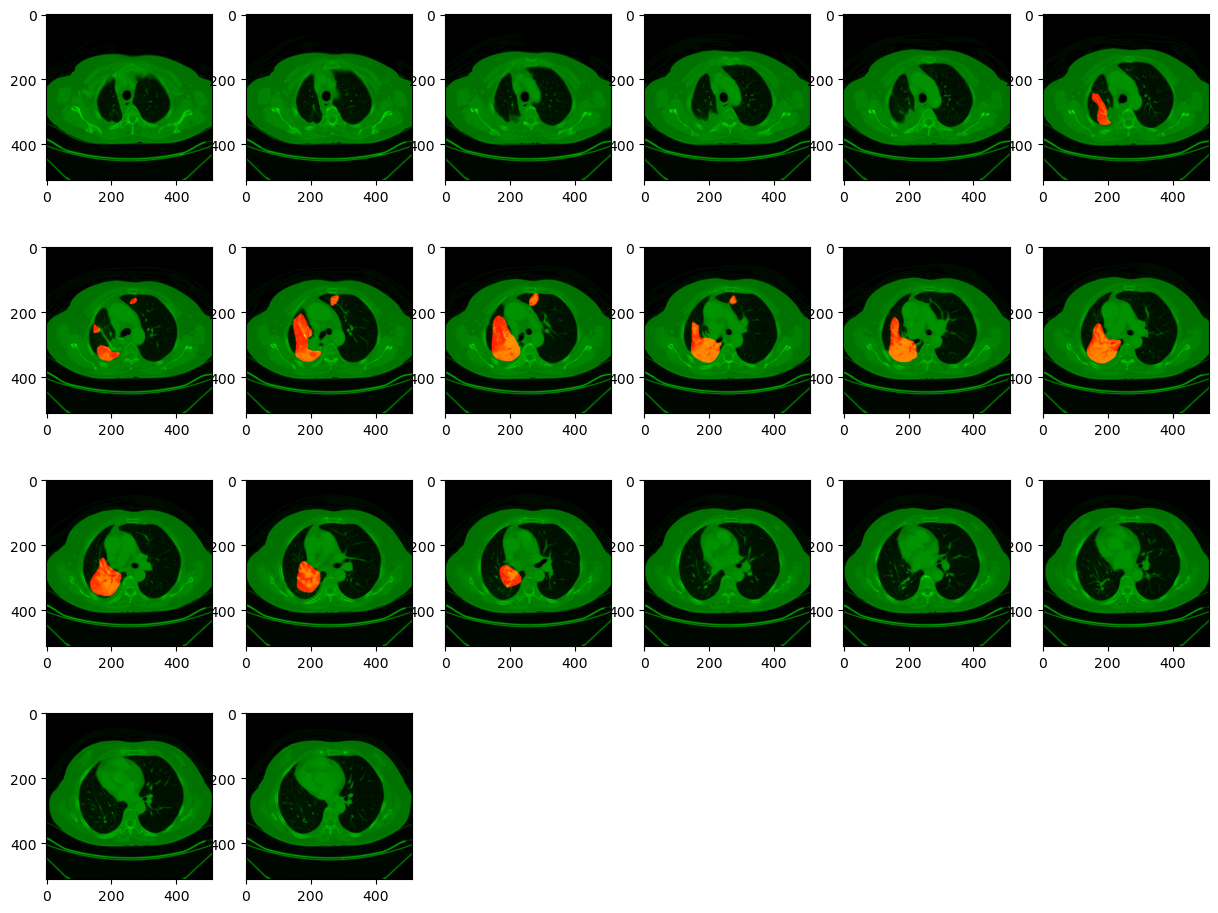

ImageSeriesReader (0x3839330): Non uniform sampling or missing slices detected,  maximum nonuniformity:30

ImageSeriesReader (0x3839330): Non uniform sampling or missing slices detected,  maximum nonuniformity:15

ImageSeriesReader (0x3839330): Non uniform sampling or missing slices detected,  maximum nonuniformity:30



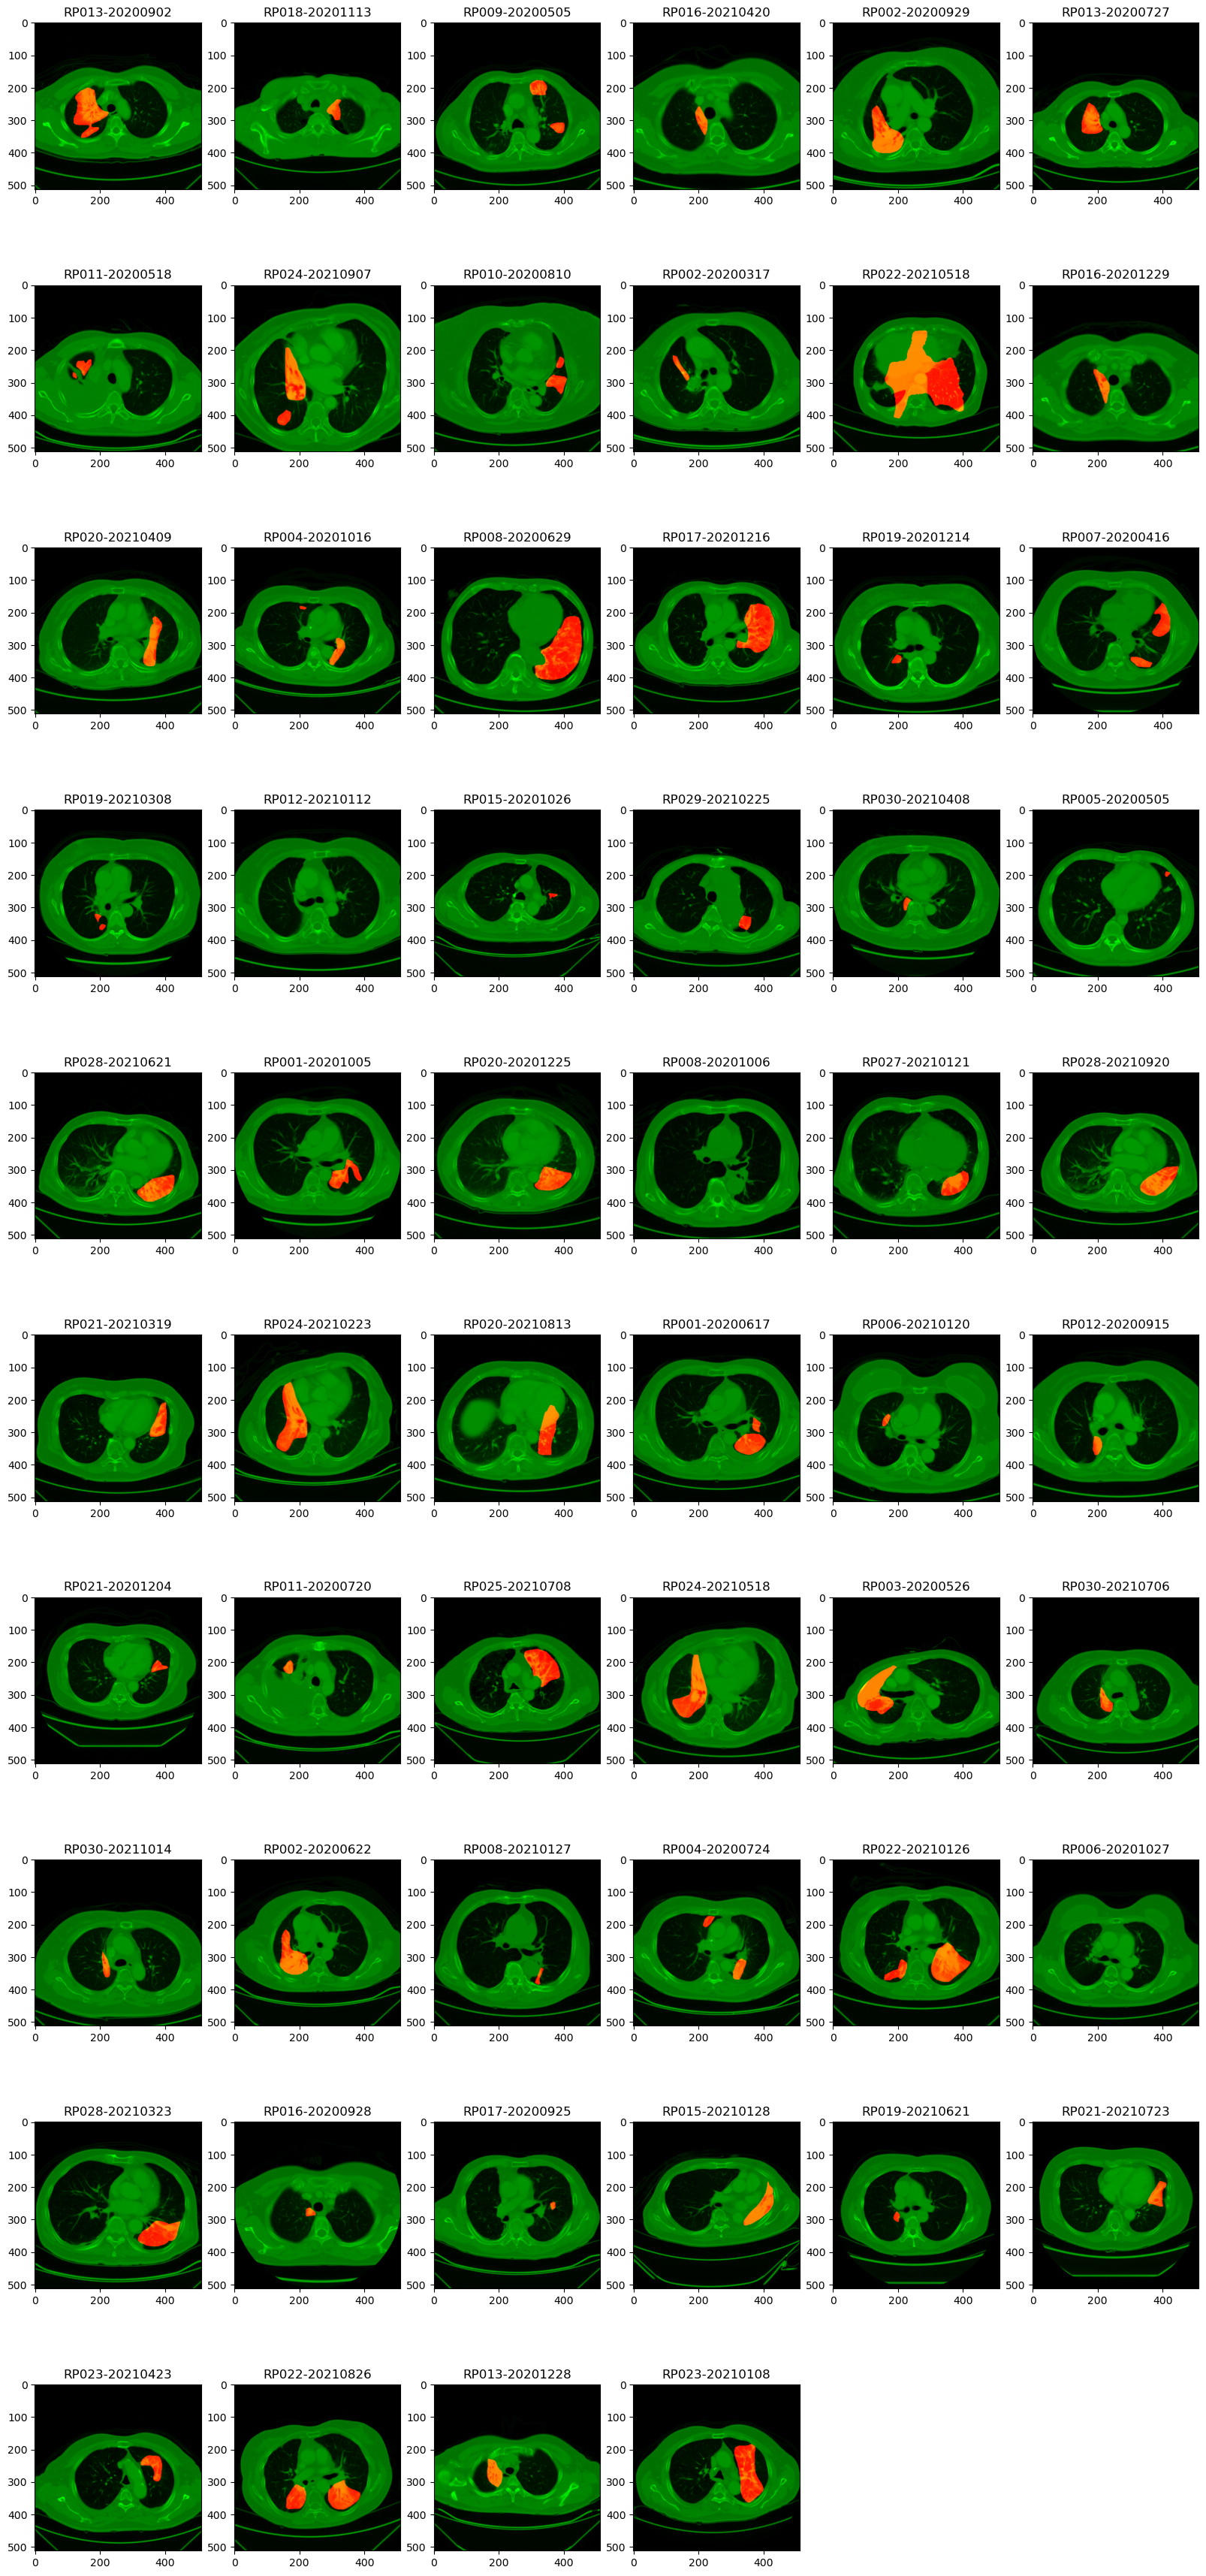

In [16]:
dcm_root = "/root/projs/rili/RILI-2019-2020/RP-2020-28p62CT/"
nrrd_root = "/root/projs/rili/RILI-2019-2020/RP-2020-28p62CT-nifty/"

# RP025-20210325 RP015-20210428 wrong shape,
# RP010-20201104 RP004-20200414 wrong ct
exclude_id = ['RP025-20210325', 'RP015-20210428', 'RP010-20201104', 'RP004-20200414']
need_to_show = ['RP010-20201104', 'RP004-20200414', 'RP002-20200622']
need_to_reverse = [
    'RP002-20200929', 'RP010-20201104', 'RP002-20200317', 'RP022-20210518', 'RP004-20201016', 'RP008-20200629',
    'RP007-20200416', 'RP004-20200414', 'RP002-20200622'
]

data2020 = data_proc(dcm_root, nrrd_root, exclude_id, need_to_show, need_to_reverse, should_shift={'RP013-20200902': -10}, debug=False)
save_npy(*data2020, save_name='2020')
show_img_mask(*data2020)
